# Sensor analysis
*Frederik Rogge, 2022*

Here, we analyze
- correlations between raw fluorescence and neuropil,
- signal-to-noise ratio, and
- signal intensity

for all the different calcium indicators.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pylab as pl
import pandas as pd

In [11]:
base_path = ''

# Load data
file_dict = {
    'local Ribo8s': [
        'path/to/file'
    ],
    'local RiboL18s': [],
    'local soma8s': [],
    'local 8s': [],
    'local 6f': [],
    'RO 8s': [],
    'RO soma8m': [],
    'RO soma8s': [],
    'RO RiboL18s': []
}

data = {}
for category in file_dict.keys():
    data[category] = {}
    for n, path in enumerate(file_dict[category]):
        data[category][path] = {}
        found = False
        for root, dirs, files in os.walk(os.path.join(base_path, path)):
            if 'iscell.npy' in files:
                data[category][path]['iscell'] = np.load(os.path.join(root, 'iscell.npy'), allow_pickle=True)
                data[category][path]['f'] = np.load(os.path.join(root, 'F.npy'), allow_pickle=True)
                data[category][path]['fneu'] = np.load(os.path.join(root, 'Fneu.npy'), allow_pickle=True)
                data[category][path]['ops'] = np.load(os.path.join(root, 'ops.npy'), allow_pickle=True).item()
                data[category][path]['stat'] = np.load(os.path.join(root, 'stat.npy'), allow_pickle=True)
                found = True
                continue
        if not found:
            print(f'No files found in {path}')

In [27]:
print(data.keys())

dict_keys(['local Ribo8s', 'local RiboL18s', 'local soma8s', 'local 8s', 'local 6f', 'RO 8s', 'RO soma8m', 'RO soma8s', 'RO RiboL18s'])


### Correlation between raw F trace and neuropil Fneu

In [17]:
corr_data = []
for i, (category, category_data) in enumerate(data.items()):

    corrs = []

    for k, v in category_data.items():

        # Get data
        iscell = v['iscell']
        f, fneu = v['f'][np.where(iscell[:, 0] > 0.5, True, False)], v['fneu'][np.where(iscell[:, 0] > 0.5, True, False)]
        n_cells = f.shape[0]

        # Calculate correlation matrix
        corr = np.corrcoef(f, fneu)

        # Select values on diagonal of upper right corner
        mask = np.concatenate([np.zeros((n_cells, n_cells)), np.eye(n_cells)], axis=1)
        mask = np.concatenate([mask, np.zeros((n_cells, corr.shape[0]))]).astype(np.bool_)
        corr = corr[mask]

        corrs.append(corr)

    corr_data.append(np.concatenate(corrs, axis=0))

### Boxplot

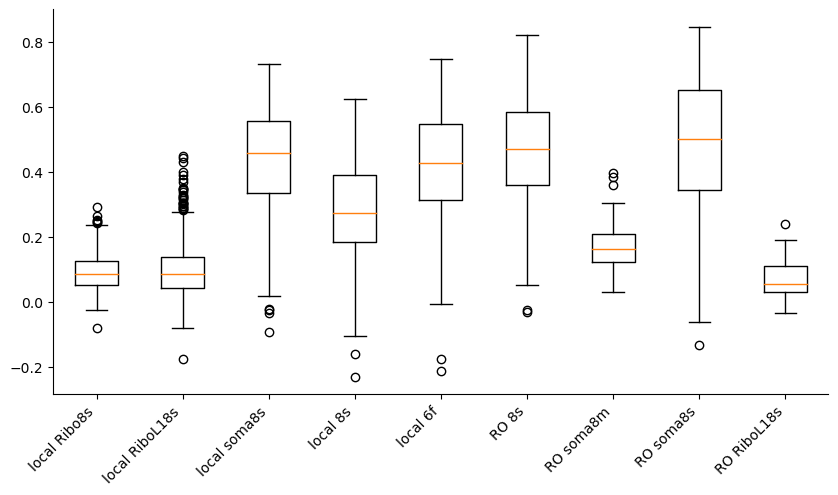

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(corr_data)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(list(data.keys()), rotation=45, ha='right')
plt.show()

Export as dataframe

In [18]:
corr_dict = {
    list(data.keys())[i]: corr_data[i] for i in range(len(list(data.keys())))
}

df = pd.DataFrame.from_dict(corr_dict, orient='index').T
print(df)

9
     local Ribo8s  local RiboL18s  local soma8s  local 8s  local 6f     RO 8s  \
0        0.129906        0.139440      0.374689  0.351071  0.532588  0.752728   
1        0.219040        0.068841     -0.026433  0.331850  0.633531  0.714407   
2        0.200365        0.165378      0.369828  0.203927  0.663480  0.585131   
3        0.074990        0.148322      0.366413 -0.231427  0.150578  0.711744   
4        0.011309        0.008035      0.514456  0.373647  0.426230 -0.030654   
..            ...             ...           ...       ...       ...       ...   
895           NaN        0.074685           NaN       NaN       NaN       NaN   
896           NaN        0.011644           NaN       NaN       NaN       NaN   
897           NaN        0.076891           NaN       NaN       NaN       NaN   
898           NaN        0.003863           NaN       NaN       NaN       NaN   
899           NaN        0.122967           NaN       NaN       NaN       NaN   

     RO soma8m  RO soma8s

### Signal-to-noise

In [20]:
sig_to_noise_ratios = []
for i, (category, category_data) in enumerate(data.items()):

    ratios = []

    for k, v in category_data.items():

        # Get data
        iscell = np.where(v['iscell'][:, 0] > 0.5, True, False)
        f, fneu = v['f'][iscell], v['fneu'][iscell]
        n_cells = f.shape[0]

        # Determine signal-to-noise ratio
        sig2noise = np.median(f, axis=1) / np.median(fneu, axis=1)

        ratios.append(sig2noise)

    sig_to_noise_ratios.append(np.concatenate(ratios, axis=0))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(sig_to_noise_ratios)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(list(data.keys()), rotation=45, ha='right')
plt.show()

Export as dataframe

In [22]:
signal_to_noise_dict = {
    list(data.keys())[i]: sig_to_noise_ratios[i] for i in range(len(list(data.keys())))
}

df = pd.DataFrame.from_dict(signal_to_noise_dict, orient='index').T
print(df)

     local Ribo8s  local RiboL18s  local soma8s  local 8s  local 6f     RO 8s  \
0        2.649011        2.200032      2.308235  2.284223  1.908678  2.306697   
1        3.479959        5.280091      1.203020  1.201949  5.897404  1.646643   
2        3.802286        3.994961      1.504606  3.766989  1.597360  1.911572   
3        2.863105        3.539126      1.367524  1.271068  1.537339  1.987660   
4        3.522846        4.539333      1.212889  1.069159  1.136939  2.013856   
..            ...             ...           ...       ...       ...       ...   
895           NaN        5.696030           NaN       NaN       NaN       NaN   
896           NaN        7.919357           NaN       NaN       NaN       NaN   
897           NaN        3.914871           NaN       NaN       NaN       NaN   
898           NaN        2.407279           NaN       NaN       NaN       NaN   
899           NaN        4.845216           NaN       NaN       NaN       NaN   

     RO soma8m  RO soma8s  

#### Signal intensity

In [24]:
signal_intensities = []
for i, (category, category_data) in enumerate(data.items()):

    signals = []

    for k, v in category_data.items():

        # Get data
        iscell = v['iscell']
        f = v['f'][np.where(iscell[:, 0] > 0.5, True, False)]
        n_cells = f.shape[0]

        # Determine signal
        signal = np.median(f, axis=1)

        signals.append(signal)

    signal_intensities.append(np.concatenate(signals, axis=0))

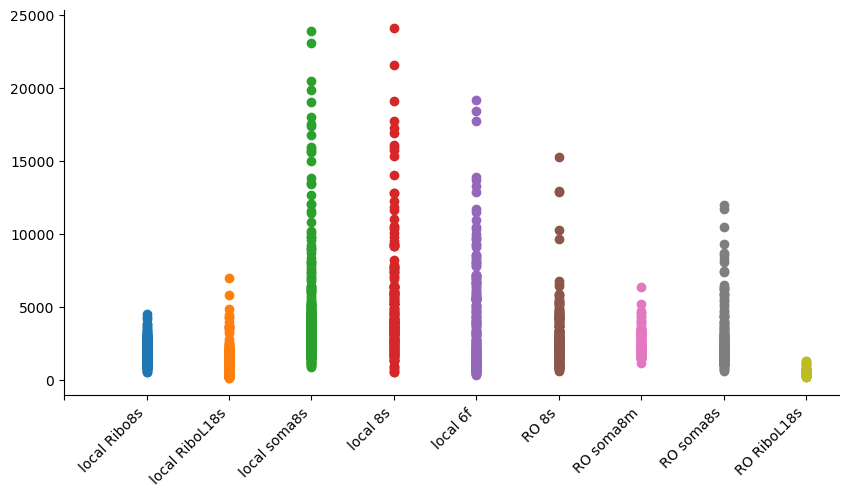

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
for i, signals in enumerate(signal_intensities):
    ax.scatter(np.ones(signals.shape[0]) * (i + 1), signals)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([i for i in range(len(signal_intensities) + 1)])
ax.set_xticklabels([''] + list(data.keys()), rotation=45, ha='right')
plt.show()

Export as dataframe

In [26]:
signal_intensities_dict = {
    list(data.keys())[i]: signal_intensities[i] for i in range(len(list(data.keys())))
}

df = pd.DataFrame.from_dict(signal_intensities_dict, orient='index').T
print(df)

     local Ribo8s  local RiboL18s  local soma8s      local 8s     local 6f  \
0     2621.649902      741.894287   6229.186523  10066.414062  3992.859131   
1     3012.158691     1837.432129   3258.779297   3320.561768  4680.397461   
2     3257.431152     1891.208130   4423.585938   3793.100830  1465.083740   
3     3161.312012     1750.632812   4875.292480   3163.344971  1123.979248   
4     1430.717285     2033.769287   3449.231445   2462.277588  3063.548340   
..            ...             ...           ...           ...          ...   
895           NaN     2124.678711           NaN           NaN          NaN   
896           NaN     3654.007324           NaN           NaN          NaN   
897           NaN     1127.000732           NaN           NaN          NaN   
898           NaN      579.788635           NaN           NaN          NaN   
899           NaN     1882.935425           NaN           NaN          NaN   

           RO 8s    RO soma8m    RO soma8s  RO RiboL18s  
0    